## Author: Terrill Toe
The initial draft to the MLsystems project.

The objective:

Use a graph profiler construct a computational graph. The graph will encapsulate all the operations within an iteration of training a model. The nodes are individual operations and the edges will represent the dependencies of input and output data

Deliverables:

- [ ] Presentation containing the following 
    - [ ] Description of the intended design for the whole project
    - [ ] pseudocode of each component with explanation.
    - [ ] current progress
    - [ ] experimental results obtained up to the midpoint
- [ ] A design document describing the first phase of the project and experimental analysis that needs to be uploaded as a PDF on Canvas.
    - [ ] design of the profiler
    - [ ] pseudocode of each component with explanation.
    - [ ] experimental analysis consisting of deliverables 4(a): Computation and memory profiling statistics and static analysis and 4(b) Peak memory consumption vs mini-batch size bar graph [w/o AC]. In general the experimental analysis on the document for each experiment should include a paragraph that describes each of the experiments, a paragraph that describes observations and a graph that demonstrates the results. When presenting, every experiment can be presented in a single slide using the graph and just enough textual info to understand the setup and results.


In [8]:
# installs
# !pip3 install seaborn
import numpy
from copy import deepcopy
from functools import wraps
import os
import logging
import torch.multiprocessing as mp
import torch
import torch.nn as nn
import torch.distributed as dist
import torch.fx as fx
from torch.fx.experimental.proxy_tensor import make_fx
from torch.distributed._functional_collectives import all_reduce
from torch.nn.parallel import DistributedDataParallel as DDP
from graph_prof import GraphProfiler
from benchmarks import Experiment, model_names, model_batch_sizes
import seaborn as sns
import matplotlib.pyplot as plt


In [9]:
class TTModel(nn.Module):
    """
    The TTModel for testing of graph profilers
    """
    def __init__(self, layers: int, dim: int):
        super().__init__()
        modules = []
        for _ in range(layers):
            modules.extend([nn.Linear(dim, dim), nn.ReLU()])
        self.mod = nn.Sequential(*modules)
        
    def forward(self, x):
        return self.mod(x)
    
def training_step(
        model: torch.nn.Module, optim: torch.optim.Optimizer, batch: torch.Tensor
):
    out: torch.Tensor = model(batch)
    out.sum().backward()
    optim.step()
    optim.zero_grad()
    
def run_worker(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'
    os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
    logging.getLogger().setLevel(logging.DEBUG if rank == 0 else logging.CRITICAL)
    if torch.backends.mps.is_available():
        logging.info(f"Torch MPS is available for this MacOS device")
    else:
        raise ValueError(f"Torch MPS is not available for this MacOS")
    if rank is None or world_size is None:
        dist.init_process_group(backend="nccl")
    # else:
    #     # dist.init_process_group(backend="gloo", rank=rank, world_size=world_size)
    logging.info(f"Number of visisble devices: {torch.cuda.device_count()}")
    # set the device to mps instead of cuda
    mps_device = torch.device("mps")
    # torch.cuda.set_device(rank)
    torch.manual_seed(20)
    batch_size = 100
    layers = 10
    dim = 100
    num_iters = 5
    model = TTModel(layers, dim).to(mps_device)
    batch = torch.randn(batch_size, dim).to(mps_device)
    optim = torch.optim.Adam(
        model.parameters(), lr=0.01, foreach=False, fused=False, capturable=True
    )
    
    for param in model.parameters():
        if param.requires_grad:
            param.register_hook(all_reduce)

In [10]:
# torch.cuda.current_device()
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [11]:
# check if the backend is set up on the mac
print(torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
print(torch.backends.mps.is_built()) #MPS is activated
print(torch.backends.mps.is_macos13_or_newer())

True
True
True


In [6]:
# run the worker to check the model can train
# rank = dist.get_rank()
# world_size = dist.get_world_size()
# run_worker(rank, world_size)

In [12]:
# create a graph profiler of the model
layers = 10
dim = 100
num_iters = 5
model = TTModel(layers, dim).to(mps_device)
TT_nn_graph = fx.symbolic_trace(model)
print(type(TT_nn_graph))

<class 'torch.fx.graph_module.GraphModule.__new__.<locals>.GraphModuleImpl'>


In [13]:
profiler_example = GraphProfiler(module=TT_nn_graph)

In [14]:
# get the node definitions
profiler_example.module.graph.print_tabular()

opcode       name    target    args       kwargs
-----------  ------  --------  ---------  --------
placeholder  x       x         ()         {}
call_module  mod_0   mod.0     (x,)       {}
call_module  mod_1   mod.1     (mod_0,)   {}
call_module  mod_2   mod.2     (mod_1,)   {}
call_module  mod_3   mod.3     (mod_2,)   {}
call_module  mod_4   mod.4     (mod_3,)   {}
call_module  mod_5   mod.5     (mod_4,)   {}
call_module  mod_6   mod.6     (mod_5,)   {}
call_module  mod_7   mod.7     (mod_6,)   {}
call_module  mod_8   mod.8     (mod_7,)   {}
call_module  mod_9   mod.9     (mod_8,)   {}
call_module  mod_10  mod.10    (mod_9,)   {}
call_module  mod_11  mod.11    (mod_10,)  {}
call_module  mod_12  mod.12    (mod_11,)  {}
call_module  mod_13  mod.13    (mod_12,)  {}
call_module  mod_14  mod.14    (mod_13,)  {}
call_module  mod_15  mod.15    (mod_14,)  {}
call_module  mod_16  mod.16    (mod_15,)  {}
call_module  mod_17  mod.17    (mod_16,)  {}
call_module  mod_18  mod.18    (mod_17,)  {}


In [8]:
for _ in range(10):
    batch = torch.randn(10, dim).to(mps_device)
    profiler_example.run(batch)

In [34]:
# profiler_example.runtimes_sec
# profiler_example.gpu_total_memory
# torch.mps.current_allocated_memory()

# get the dictionary of forward passes
# for key in profiler_example.env.keys():
#     profiler_example.env[key] = profiler_example.env[key].to('cpu')

# profiler_example.
new_dict = {}
try:
    new_dict['example']['test'] = 1
except:
    print('example not in dict, inserting...')
    new_dict['example'] = {}
    new_dict['example']['test'] = 1
new_dict

example not in dict, inserting...


{'example': {'test': 1}}

In [15]:
# get the model from experiments
# !pip install transformers
exp = Experiment(model_names[1], model_batch_sizes[model_names[1]])
exp.model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
bert_nn_graph = fx.symbolic_trace(exp.model)
bert_profiler = GraphProfiler(module=bert_nn_graph)

In [17]:
# type(bert_profiler.module.graph.nodes)
counter = 0
node_example = None
for node in bert_profiler.module.graph.nodes:
    print(type(node))
    node_example = node
    if counter == 1:
        break
    counter += 1

print(type(node_example))

<class 'torch.fx.node.Node'>
<class 'torch.fx.node.Node'>
<class 'torch.fx.node.Node'>


In [20]:
# type(bert_nn_graph)
args_list = [*node_example.args]
type(args_list[0])

torch.fx.node.Node

In [9]:
# batch = torch.randn(10, 10).to(mps_device)
# bert_profiler.run(batch)
bert_profiler.module.graph.print_tabular()

opcode         name                   target                                                   args                                   kwargs
-------------  ---------------------  -------------------------------------------------------  -------------------------------------  --------
placeholder    x                      x                                                        ()                                     {}
call_module    conv1                  conv1                                                    (x,)                                   {}
call_module    bn1                    bn1                                                      (conv1,)                               {}
call_module    relu                   relu                                                     (bn1,)                                 {}
call_module    maxpool                maxpool                                                  (relu,)                                {}
call_module    layer1_0_conv1  

In [29]:
node_example

conv1

In [21]:
batch = torch.randn(10, 10).to(mps_device)
bert_profiler.run(exp.example_inputs[0].to(mps_device))

result tpye: tensor([[[[-2.3808e-01,  1.2310e-01,  3.7484e-01,  ...,  1.8752e-01,
            2.6557e-01,  2.5595e-01],
          [-4.1534e-02,  2.2615e-01,  3.6662e-01,  ...,  3.1976e-01,
            1.1394e-01,  3.0516e-01],
          [ 2.4334e-02,  9.9424e-02,  2.1580e-01,  ..., -1.9027e-02,
           -8.7704e-02,  2.6897e-01],
          ...,
          [-2.6824e-01, -3.0739e-01, -1.1267e-01,  ...,  5.4044e-01,
            4.8184e-01, -1.4545e-01],
          [ 1.5491e-01, -1.4385e-02,  3.6364e-01,  ...,  1.3611e-01,
            4.2657e-02, -2.8735e-02],
          [ 6.9487e-02, -1.0034e-01,  3.0803e-01,  ..., -3.3846e-02,
           -2.9071e-01, -1.6230e-02]],

         [[-2.1286e-01,  3.5616e-01,  4.2619e-01,  ...,  2.0141e-01,
            2.0388e-01,  4.9847e-01],
          [ 2.2597e-01,  5.1519e-01,  3.4030e-01,  ...,  4.8315e-01,
            2.6594e-01,  5.0584e-01],
          [ 1.8572e-01,  3.2741e-01,  2.0793e-01,  ...,  4.4620e-01,
            2.9306e-01,  3.1783e-01],
       

tensor([[ 0.1312,  1.9405,  0.1792,  ..., -0.1448,  2.0765,  1.5551],
        [-1.8894, -0.8368, -0.4586,  ..., -1.1372,  1.0060, -0.2135],
        [-1.2001, -1.6034, -0.3141,  ...,  0.0958,  1.4415,  2.1605],
        [-0.9298, -0.5995, -1.6232,  ..., -0.6584,  0.1702,  0.0969]],
       device='mps:0', grad_fn=<LinearBackward0>)

In [20]:
len(exp.example_inputs)

1

In [28]:
bert_nn_graph = fx.symbolic_trace(exp.model)
print(bert_nn_graph.graph)

graph():
    %x : torch.Tensor [num_users=1] = placeholder[target=x]
    %conv1 : [num_users=1] = call_module[target=conv1](args = (%x,), kwargs = {})
    %bn1 : [num_users=1] = call_module[target=bn1](args = (%conv1,), kwargs = {})
    %relu : [num_users=1] = call_module[target=relu](args = (%bn1,), kwargs = {})
    %maxpool : [num_users=2] = call_module[target=maxpool](args = (%relu,), kwargs = {})
    %layer1_0_conv1 : [num_users=1] = call_module[target=layer1.0.conv1](args = (%maxpool,), kwargs = {})
    %layer1_0_bn1 : [num_users=1] = call_module[target=layer1.0.bn1](args = (%layer1_0_conv1,), kwargs = {})
    %layer1_0_relu : [num_users=1] = call_module[target=layer1.0.relu](args = (%layer1_0_bn1,), kwargs = {})
    %layer1_0_conv2 : [num_users=1] = call_module[target=layer1.0.conv2](args = (%layer1_0_relu,), kwargs = {})
    %layer1_0_bn2 : [num_users=1] = call_module[target=layer1.0.bn2](args = (%layer1_0_conv2,), kwargs = {})
    %layer1_0_relu_1 : [num_users=1] = call_module[

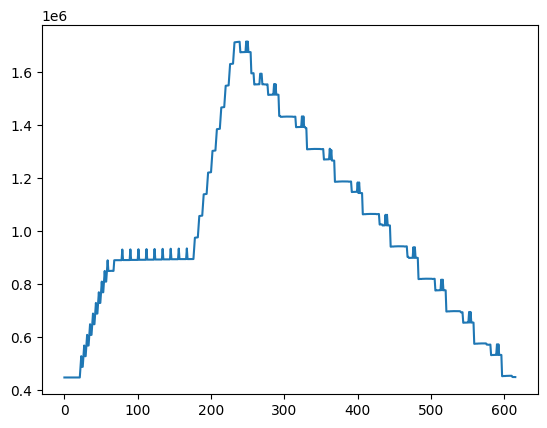

In [12]:
# plot the memory
mem_usage = [447232, 447232, 447232, 447232, 447232, 447232, 447232, 447232, 447232, 447232, 447232, 447232, 447232, 447232, 447232, 447232, 447232, 447232, 447232, 447232, 447232, 447232, 487424, 527616, 487424, 487424, 527616, 567808, 527616, 527616, 567808, 608000, 567808, 567808, 608000, 648192, 608000, 608000, 648192, 688384, 648192, 648192, 688384, 728576, 688384, 688384, 728576, 768768, 728576, 728576, 768768, 808960, 768768, 768768, 808960, 849152, 808960, 808960, 849152, 889344, 849152, 849152, 849152, 849408, 849664, 849408, 849408, 849408, 889600, 889856, 889856, 889856, 889856, 889856, 889856, 889856, 889856, 889856, 889856, 930048, 890368, 890368, 890368, 890368, 890368, 890368, 890368, 890368, 890368, 890368, 930560, 890880, 890880, 890880, 890880, 890880, 890880, 890880, 890880, 890880, 890880, 931072, 891392, 891392, 891392, 891392, 891392, 891392, 891392, 891392, 891392, 891392, 931584, 891904, 891904, 891904, 891904, 891904, 891904, 891904, 891904, 891904, 891904, 932096, 892416, 892416, 892416, 892416, 892416, 892416, 892416, 892416, 892416, 892416, 932608, 892928, 892928, 892928, 892928, 892928, 892928, 892928, 892928, 892928, 892928, 933120, 893440, 893440, 893440, 893440, 893440, 893440, 893440, 893440, 893440, 893440, 933632, 893952, 893952, 893952, 893952, 893952, 893952, 893952, 893952, 893952, 893952, 934144, 893952, 893952, 893952, 893952, 893952, 893952, 893952, 893952, 894208, 934400, 974592, 974848, 975360, 975872, 976128, 1016320, 1056512, 1056768, 1057280, 1057792, 1058048, 1098240, 1138432, 1138688, 1139200, 1139712, 1139968, 1180160, 1220352, 1220608, 1221120, 1221632, 1221888, 1262080, 1302272, 1302528, 1303040, 1303552, 1303808, 1344000, 1384192, 1384448, 1384960, 1385472, 1385728, 1425920, 1466112, 1466368, 1466880, 1467392, 1467648, 1507840, 1548032, 1548288, 1548800, 1549312, 1549568, 1589760, 1629952, 1630208, 1630720, 1631232, 1631488, 1671680, 1711872, 1712128, 1712640, 1713152, 1713408, 1713664, 1713920, 1714176, 1674240, 1674752, 1674752, 1675008, 1675008, 1675264, 1675264, 1675264, 1715200, 1675264, 1715200, 1675008, 1675264, 1675008, 1675008, 1594880, 1595136, 1595392, 1595648, 1552640, 1553152, 1553152, 1553408, 1553408, 1553664, 1553664, 1553664, 1593600, 1593344, 1593600, 1553408, 1553664, 1553408, 1553408, 1552640, 1552896, 1553152, 1553408, 1513472, 1513984, 1513984, 1514240, 1514240, 1514496, 1514496, 1514496, 1554432, 1514496, 1554432, 1514240, 1514496, 1514240, 1514240, 1434112, 1434368, 1430784, 1431040, 1430784, 1431296, 1431296, 1431552, 1431552, 1431808, 1431808, 1431808, 1432064, 1431808, 1432064, 1431552, 1431808, 1431552, 1431552, 1430784, 1431040, 1431296, 1431552, 1391616, 1392128, 1392128, 1392384, 1392384, 1392640, 1392640, 1392640, 1432576, 1392640, 1432576, 1392384, 1392640, 1388288, 1388288, 1308160, 1308416, 1308672, 1308928, 1308672, 1309184, 1309184, 1309440, 1309440, 1309696, 1309696, 1309696, 1309952, 1309696, 1309952, 1309440, 1309696, 1309440, 1309440, 1308672, 1308928, 1309184, 1309440, 1269504, 1270016, 1270016, 1270272, 1270272, 1270528, 1270528, 1270528, 1310464, 1270528, 1305856, 1265664, 1265920, 1265664, 1265664, 1185536, 1185792, 1186048, 1186304, 1186048, 1186560, 1186560, 1186816, 1186816, 1187072, 1187072, 1187072, 1187328, 1187072, 1187328, 1186816, 1187072, 1186816, 1186816, 1186048, 1186304, 1186560, 1186816, 1146880, 1147392, 1147392, 1147648, 1147648, 1147904, 1147904, 1147904, 1183232, 1143296, 1183232, 1143040, 1143296, 1143040, 1143040, 1062912, 1063168, 1063424, 1063680, 1063424, 1063936, 1063936, 1064192, 1064192, 1064448, 1064448, 1064448, 1064704, 1064448, 1064704, 1064192, 1064448, 1064192, 1064192, 1063424, 1063680, 1063936, 1064192, 1024256, 1024768, 1024768, 1025024, 1020928, 1021184, 1021184, 1021184, 1061120, 1021184, 1061120, 1020928, 1021184, 1020928, 1020928, 940800, 941056, 941312, 941568, 941312, 941824, 941824, 942080, 942080, 942336, 942336, 942336, 942592, 942336, 942592, 942080, 942336, 942080, 942080, 941312, 941568, 941824, 942080, 902144, 902656, 898304, 898560, 898560, 898816, 898816, 898816, 938752, 898816, 938752, 898560, 898816, 898560, 898560, 818432, 818688, 818944, 819200, 818944, 819456, 819456, 819712, 819712, 819968, 819968, 819968, 820224, 819968, 820224, 819712, 819968, 819712, 819712, 818944, 819200, 819456, 819712, 775424, 775936, 775936, 776192, 776192, 776448, 776448, 776448, 816384, 776448, 816384, 776192, 776448, 776192, 776192, 696064, 696320, 696576, 696832, 696576, 697088, 697088, 697344, 697344, 697600, 697600, 697600, 697856, 697600, 697856, 697344, 697600, 697344, 697344, 696576, 692992, 693248, 693504, 653568, 654080, 654080, 654336, 654336, 654592, 654592, 654592, 694528, 654592, 694528, 654336, 654592, 654336, 654336, 574208, 574464, 574720, 574976, 574720, 575232, 575232, 575488, 575488, 575744, 575744, 575744, 576000, 575744, 576000, 575488, 575744, 571392, 571392, 570624, 570880, 571136, 571392, 531456, 531968, 531968, 532224, 532224, 532480, 532480, 532480, 572416, 532480, 572416, 532224, 532480, 532224, 532224, 452096, 452352, 452608, 452864, 452608, 453120, 453120, 453376, 453376, 453632, 453632, 453632, 453888, 453632, 449280, 448768, 449024, 448768, 448768]
node_num = [x for x in range(len(mem_usage))]

sns.lineplot(x=node_num, y=mem_usage)
plt.show()

In [38]:
for value in profiler_example.env.values():
    torch.numel(value)